# **Movie Recommendation System  -  `Team L`**

Falaras Apostolis  /  2981  /  afalaras@uth.gr

Maipas Kosmas  /  2567  /  kmaipas@uth.gr

Sialtsis Alexandros  /  3083  /  asialtsis@uth.gr

## 1. Introduction

**Recommendation systems**, also commonly referred to as  recommender systems, are software applications that use a subset of machine learning methods and algorithms. Their goal is to analyze user preferences about content and products, in order to make personalized recommendations to the users about content and products they haven't interacted with and might find interesting. There are various types of recommendation systems, including collaborative filtering, content-based filtering, and hybrid methods. Each type consists of it's distinct methods and algorithms.

**Recommendation systems** play a crucial role in today's digital world, as they can be found across various diverse applications. They are responsible for helping users navigate and find what they are looking for amid the overwhelming amount of information on the internet.  Additionally, they can adapt to the users' evolving preferences, ensuring that users stay engaged to the application as their interests change over time. This not only leads to a more pleasant and time-efficient user experience but also it increases business profit as businesses can retain more customers.  

## 2. Dataset

We have decided to build a movie recommendation system, using the [netflix-prize-data](https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data/) movie ratings dataset from kaggle. The dataset contains four text files (combined_data_1.txt, combined_data_2.txt, combined_data_3.txt and combined_data_4.txt) and a csv file (movie_titles.csv).

Each one of the text files contains the ratings for the movies in the following format:
```python
MovieId:
CustomerID_1,Rating_1,Date_1
CustomerID_2,Rating_2,Date_2
```

For example:
```python
1:
1488844,3,2005-09-06
822109,5,2005-05-13
2:
2059652,4,2005-09-05
1666394,3,2005-04-19
```
The movie_titles.csv file contains the title and release year for each movie.

---------------------
**IN ORDER FOR THIS NOTEBOOK TO WORK**, you need to
**download** this dataset and store it in a directory with the name **"dataset"**


## 3. Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from datetime import datetime
from scipy import sparse
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 4. Exploratory Data Analysis (EDA)

If you want to run this notebook on Google Colab, switch the `is_colab` flag to `True`.

In [ ]:
is_colab = False

if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    os.listdir('drive/MyDrive/machine_learning/Final_Project')
    path = 'drive/MyDrive/machine_learning/Final_Project'

Mounted at /content/drive


### 4.1 Creating .csv file from text files

In [ ]:
# The first step is to create the .csv file that will contain the user-movie ratings matrix.
# If the the ratings.csv doesn't exist in the current folder, we create it there.

if not os.path.isfile("dataset/ratings_1.csv"):
    ratings_1 = open("dataset/ratings_1.csv", mode="w")
    ratings_2 = open("dataset/ratings_2.csv", mode="w")
    ratings_3 = open("dataset/ratings_3.csv", mode="w")
    ratings_4 = open("dataset/ratings_4.csv", mode="w")


    ratings_files = ["dataset/combined_data_1.txt", "dataset/combined_data_2.txt", "dataset/combined_data_3.txt", "dataset/combined_data_4.txt"]
    ratings_csvs = [ratings_1, ratings_2, ratings_3, ratings_4]

    for file, ratings in zip(ratings_files,ratings_csvs):
        movie_id = 0
        with open(file) as f:
            for line in f:
                line = line.strip()
                line = line.split(",")


                if line[0].endswith(":"):
                    movie_id = line[0].replace(":","")
                else:
                    line.insert(0,str(movie_id))
                    ratings.write(str(",".join(line)))
                    ratings.write("\n")

    ratings_1.close()
    ratings_2.close()
    ratings_3.close()
    ratings_4.close()

### 4.2 DataFrame overview

In [ ]:
df_1 = pd.read_csv("dataset/ratings_1.csv",header=None,sep=",",names=["Movie_ID","User_ID","Rating","Date"])
df_2 = pd.read_csv("dataset/ratings_2.csv",header=None,sep=",",names=["Movie_ID","User_ID","Rating","Date"])
df_3 = pd.read_csv("dataset/ratings_3.csv",header=None,sep=",",names=["Movie_ID","User_ID","Rating","Date"])
df_4 = pd.read_csv("dataset/ratings_4.csv",header=None,sep=",",names=["Movie_ID","User_ID","Rating","Date"])
df = pd.concat([df_1,df_2,df_3,df_4], axis=0, ignore_index=True)

df.head()

,Unnamed: 0,Movie_ID,User_ID,Rating,Date,Day_of_Week
0,49422235,8903,28966,1,1999-12-30,Thursday
1,62828404,11405,28966,4,1999-12-30,Thursday
2,87462364,15532,28966,1,1999-12-30,Thursday
3,87033901,15455,1086,1,1999-12-31,Friday
4,28357719,5237,1086,5,1999-12-31,Friday


**Note:** We chose to keep the the first 10000 users in terms of their ID, because, even for 50000 users the required space for the matrix of the predicted ratings of the SVD algorithm was 1.15 GB, as reported by the $\texttt{MemoryError}$ message. We use '55395' in the condition below, because not all possible integer User_ID values are included in the dataset and 55395 was the appropriate number to use to narrow down to 10000 users.

In [ ]:
df = df[df["User_ID"] <= 55395]
print("Dataset dimensions: ", df.shape)

In [ ]:
print("Total number of ratings:", df.shape[0])
print("Total number of users:", len(np.unique(df["User_ID"])))
print("Total number of movies:", len(np.unique(df["Movie_ID"])))

Total number of ratings: 2097444
Total number of users: 10000
Total number of movies: 17300


In [ ]:
num_users = len(np.unique(df["User_ID"]))
num_movies = len(np.unique(df["Movie_ID"]))

**Note:** Variables 'num_movies' and 'num_movies' were used later in the notebook.  

### 4.3 Checking for NaN and duplicate values

In [ ]:
print("Number of NaN values:\n" + str(df.isnull().sum()))

duplicates = sum(df.duplicated(["Movie_ID","User_ID","Rating"]))
print("\nNumber of duplicate values:", duplicates)

Number of NaN values:
Unnamed: 0     0
Movie_ID       0
User_ID        0
Rating         0
Date           0
Day_of_Week    0
dtype: int64

Number of duplicate values: 0


### 4.4 Checking basic statistics and distribution of ratings

In [ ]:
df.describe()["Rating"]

count    2.097444e+06
mean     3.616566e+00
std      1.082779e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

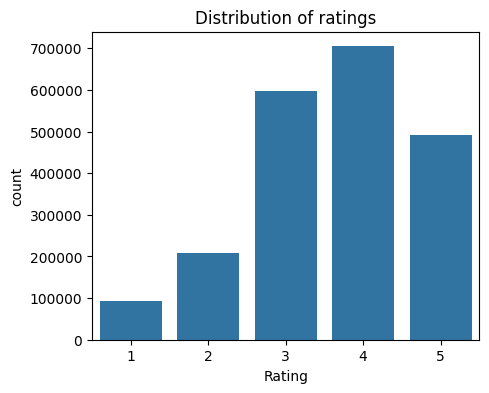

In [ ]:
plt.figure(figsize=(5,4))
plt.title("Distribution of ratings")
sns.countplot(x="Rating",data=df)
plt.show()

**Conclusion:** We observe that the majority of users are more likely to give higher ratings to the movies.

### 4.5 Analysis of per-user ratings

Performing Exploratory Data Analysis on the per-user ratings can help us understand how users engage with the system and gain insights on user behaviour and preferences in the recommendation system. We can identify the most active users by calculating the number of ratings per user. Moreover, we can examine the average rating of users, in order to determine whether or not a user has been satisfied with the recommendation system.

### 4.5.1 Number of ratings per user

In [ ]:
ratings_per_user = df.groupby(by="User_ID")["Rating"].count().sort_values(ascending=False)
print(ratings_per_user.head())

User_ID
16272    5900
3321     4395
49890    3295
1333     2982
11043    2911
Name: Rating, dtype: int64


In [ ]:
# descriptive statistics for per-user ratings
print(ratings_per_user.describe())

count    10000.000000
mean       209.744400
std        295.282103
min          1.000000
25%         38.000000
50%         99.000000
75%        263.000000
max       5900.000000
Name: Rating, dtype: float64


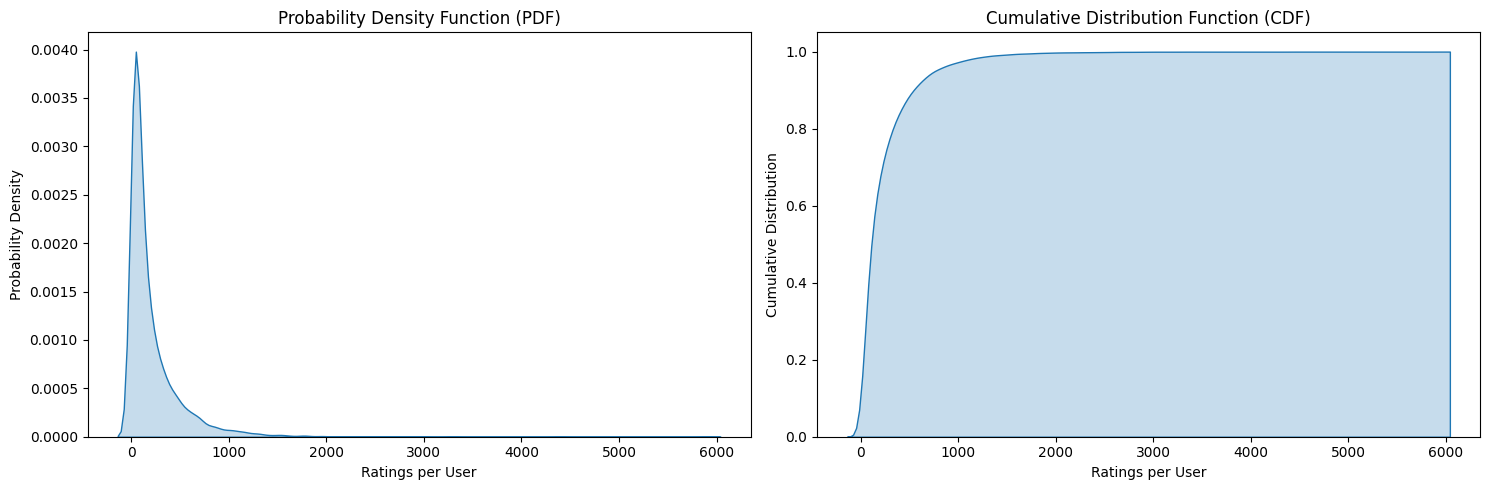

In [ ]:
# Probability Density Function and Cumulative Distribution Function of per-user ratings

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

sns.kdeplot(ax=ax[0], data=ratings_per_user, fill=True)
ax[0].set_title("Probability Density Function (PDF)")
ax[0].set_xlabel("Ratings per User")
ax[0].set_ylabel("Probability Density")

sns.kdeplot(ax=ax[1], data=ratings_per_user, cumulative=True, fill=True)
ax[1].set_title("Cumulative Distribution Function (CDF)")
ax[1].set_xlabel("Ratings per User")
ax[1].set_ylabel("Cumulative Distribution")

plt.tight_layout()
plt.show()

**Conclusion**: From the above PDF and CDF we conclude that the vast majority of users have either very few or zero number of ratings. This is expected, because many users probably interact with a small fraction of the total movies in the recommendation system.

### 4.5.2 Average rating per user

In [ ]:
df.loc[:,"Rating"] = pd.to_numeric(df["Rating"])
average_ratings = df.groupby("User_ID")["Rating"].mean().sort_values(ascending=False)
print(average_ratings.head())

User_ID
10023    5.0
33959    5.0
1365     5.0
45569    5.0
15007    5.0
Name: Rating, dtype: float64


In [ ]:
# descriptive statistics for average ratings per user
print(average_ratings.describe())

count    10000.000000
mean         3.676128
std          0.472650
min          1.000000
25%          3.388568
50%          3.677251
75%          3.981711
max          5.000000
Name: Rating, dtype: float64


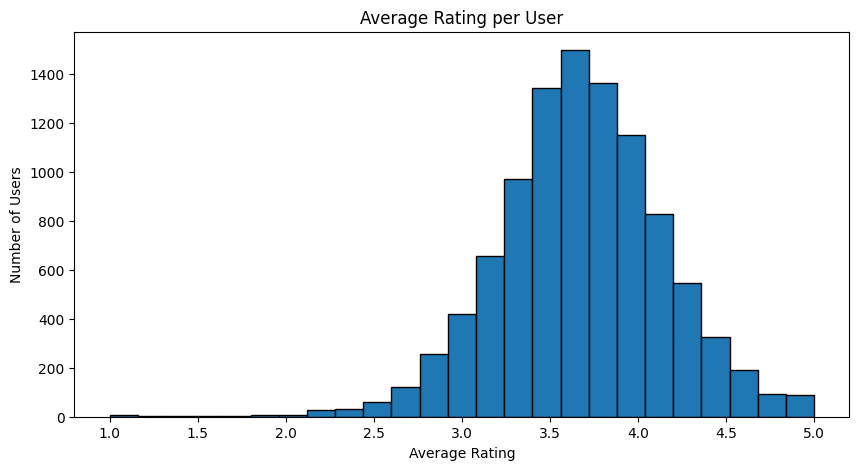

In [ ]:
# Histogram of average ratings per user

plt.figure(figsize=(10,5))
plt.hist(average_ratings, bins=25, edgecolor="black")
plt.title("Average Rating per User")
plt.xlabel("Average Rating")
plt.ylabel("Number of Users")
plt.show()

### 4.6 Analysis of per-movie ratings

Performing Exploratory Data Analysis on the per-movie ratings is an important task that can help us obtain useful information about user preferences as well as movie characteristics. Also, by calculating the number of ratings and the average rating, we can not only identify blockbuster movies, but also discover "hidden-gems" (movies with very high average rating and low popularity). Additionally, we can implement temporal analysis of movie ratings, in order to observe how they change over time.

### 4.6.1 Number of ratings per movie

In [ ]:
ratings_per_movie = df.groupby(by="Movie_ID")["Rating"].count().sort_values(ascending=False)
print(ratings_per_movie.head())

Movie_ID
5317     4907
15124    4576
14313    4198
1905     4068
15205    4036
Name: Rating, dtype: int64


In [ ]:
# descriptive statistics for per-movie ratings
print(ratings_per_movie.describe())

count    17300.000000
mean       121.239538
std        359.222825
min          1.000000
25%          4.000000
50%         12.000000
75%         59.000000
max       4907.000000
Name: Rating, dtype: float64


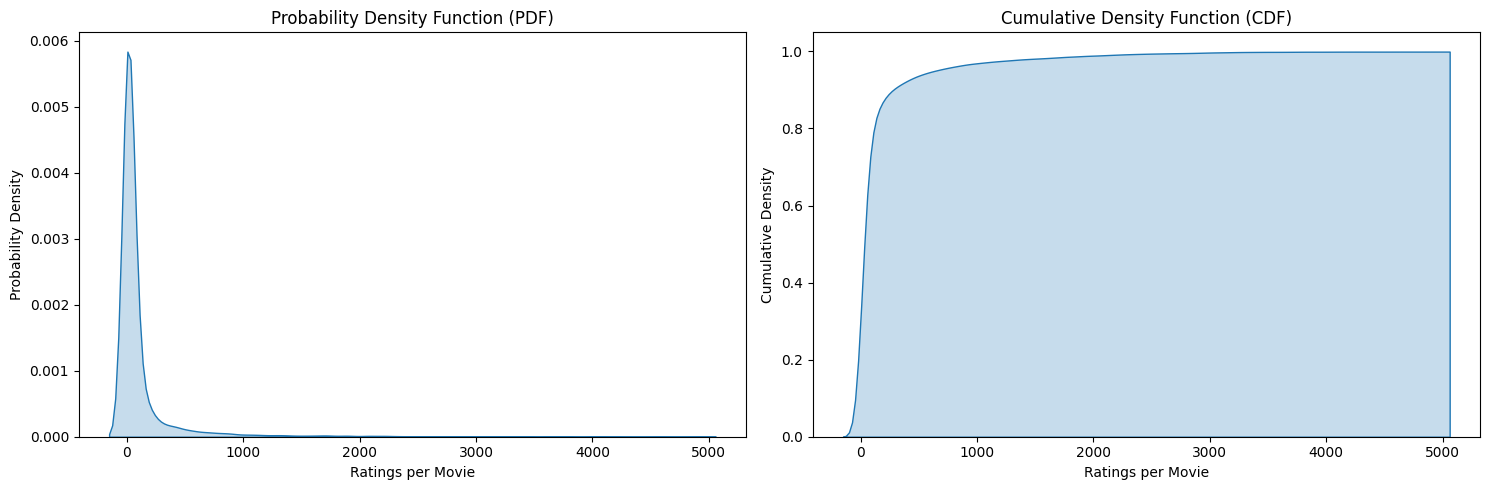

In [ ]:
# Probability Density Function and Cumulative Distribution Function of per-movie ratings

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

sns.kdeplot(ax=ax[0], data=ratings_per_movie, fill=True)
ax[0].set_title("Probability Density Function (PDF)")
ax[0].set_xlabel("Ratings per Movie")
ax[0].set_ylabel("Probability Density")

sns.kdeplot(ax=ax[1], data=ratings_per_movie, cumulative=True, fill=True)
ax[1].set_title("Cumulative Density Function (CDF)")
ax[1].set_xlabel("Ratings per Movie")
ax[1].set_ylabel("Cumulative Density")

plt.tight_layout()
plt.show()

**Conclusion**: From the above PDF and CDF we conclude that the vast majority of movies have either very few or zero number of ratings. This is expected, because not all movies are popular among the vast majority users so that they can be rated.

### 4.6.2 Average rating per movie

In [ ]:
df.loc[:,"Rating"] = pd.to_numeric(df["Rating"])
average_ratings = df.groupby("Movie_ID")["Rating"].mean().sort_values(ascending=False)
print(average_ratings.head())

Movie_ID
16354    5.0
13118    5.0
8443     5.0
365      5.0
13399    5.0
Name: Rating, dtype: float64


In [ ]:
# descriptive statistics for average ratings per movie
print(average_ratings.describe())

count    17300.000000
mean         3.276097
std          0.709097
min          1.000000
25%          2.925779
50%          3.340909
75%          3.750000
max          5.000000
Name: Rating, dtype: float64


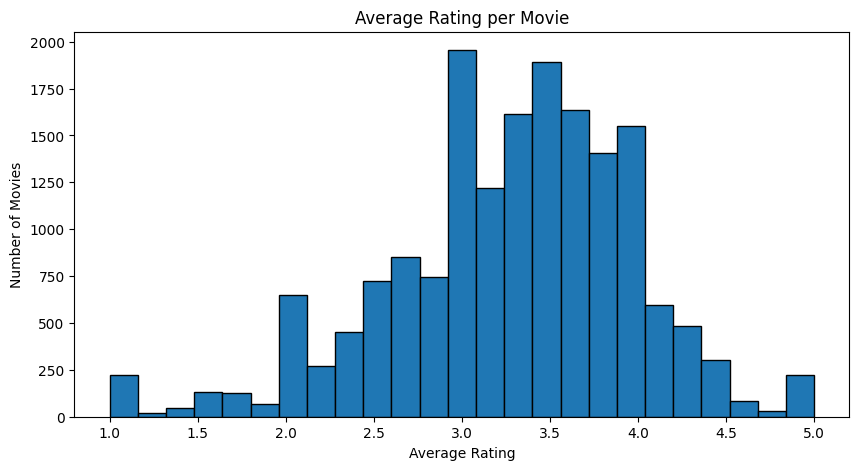

In [ ]:
# Histogram of average rating per movie

plt.figure(figsize=(10,5))
plt.hist(average_ratings, bins=25, edgecolor="black")
plt.title("Average Rating per Movie")
plt.xlabel("Average Rating")
plt.ylabel("Number of Movies")
plt.show()

## 4.7 Temporal Analysis of ratings

### 4.7.1 Montly analysis of ratings

The first step of the montly analysis of ratings is to sort the dataframe in an ascending order of dates.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
df.head()

,Unnamed: 0,Movie_ID,User_ID,Rating,Date,Day_of_Week
0,49422235,8903,28966,1,1999-12-30,Thursday
1,62828404,11405,28966,4,1999-12-30,Thursday
2,87462364,15532,28966,1,1999-12-30,Thursday
24,65590856,12034,1086,5,1999-12-31,Friday
23,1349997,295,1086,4,1999-12-31,Friday


Text(0.5, 1.0, 'Number of ratings per month')

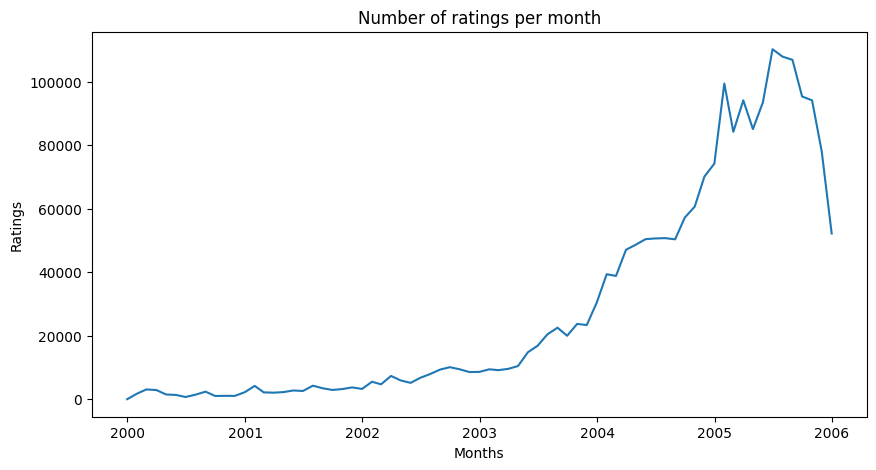

In [ ]:
montly_ratings = df.resample('M', on='Date')['Rating'].count()

plt.figure(figsize=(10,5))
plt.plot(montly_ratings)
plt.xlabel('Months')
plt.ylabel('Ratings')
plt.title('Number of ratings per month')

**Conclusion:** The graph of monthly ratings over time, gives us valuable information about user engagement. During high user activity we can assume that some popular highly-anticipated movies have just been introduced to the system. During low user activity we may need to perform better recommendations to users, in order to increase the ratings totals.

### 4.7.2 Daily analysis of ratings

The first step of the daily analysis of ratings is to add a new column in the dataframe, the day the users rated each movies.

In [ ]:
df['Day_of_Week'] = df['Date'].dt.day_name()
df.head()

,Unnamed: 0,Movie_ID,User_ID,Rating,Date,Day_of_Week
0,49422235,8903,28966,1,1999-12-30,Thursday
1,62828404,11405,28966,4,1999-12-30,Thursday
2,87462364,15532,28966,1,1999-12-30,Thursday
24,65590856,12034,1086,5,1999-12-31,Friday
23,1349997,295,1086,4,1999-12-31,Friday


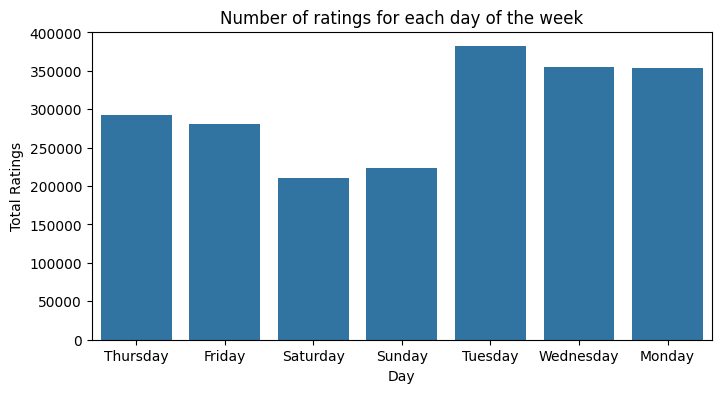

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='Day_of_Week',data=df)
plt.xlabel('Day')
plt.ylabel('Total Ratings')
plt.title('Number of ratings for each day of the week')
plt.show()

**Conclusion:** From the countplot above, we can observe that Monday, Tuesday and Wednesday are the days with the most active users, with over 350000 ratings each day. The rest of the days showcase lower number of ratings. The distribution of the number of ratings per day is influenced by the users' routines and daily activities.

It's also worth checking the average rating per day.

In [ ]:
average_daily_ratings = df.groupby(by=['Day_of_Week'])['Rating'].mean()
print("Average Daily Ratings:")
print(average_daily_ratings)

Average Daily Ratings:
Day_of_Week
Friday       3.615100
Monday       3.594371
Saturday     3.648928
Sunday       3.607942
Thursday     3.629727
Tuesday      3.608991
Wednesday    3.623424
Name: Rating, dtype: float64


**Conclusion:** The daily average ratings are almost the same, so there is no correlation between the total number of ratings per day of the week and the daily average rating.

## 5. Splitting the Dataset to Training and Test Set

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

display(train_data.head())
display(test_data.head())

,Unnamed: 0,Movie_ID,User_ID,Rating,Date,Day_of_Week
559140,25815715,4801,8055,3,2004-05-17,Monday
1014218,78403547,14240,43185,4,2005-01-06,Thursday
1204689,46789536,8387,43489,5,2005-03-08,Tuesday
1121051,62303503,11314,40031,3,2005-02-09,Wednesday
842579,22647238,4290,54870,1,2004-10-26,Tuesday


,Unnamed: 0,Movie_ID,User_ID,Rating,Date,Day_of_Week
1105764,84941554,15110,5308,4,2005-02-03,Thursday
1327990,4284286,819,13197,3,2005-04-19,Tuesday
321927,63299672,11521,42870,5,2003-11-23,Sunday
1001556,87450237,15532,4171,4,2005-01-02,Sunday
381509,24964285,4660,11393,2,2004-01-20,Tuesday


## 6. Creating User-Item Ratings Matrix

In [ ]:
user_to_index = {user_id: index for index, user_id in enumerate(np.unique(df['User_ID']))}
movie_to_index = {item_id: index for index, item_id in enumerate(np.unique(df['Movie_ID']))}

user_indices = np.vectorize(user_to_index.get)(df['User_ID'])
movie_indices = np.vectorize(movie_to_index.get)(df['Movie_ID'])

sparse_matrix = sparse.coo_matrix((df['Rating'], (user_indices, movie_indices)))

sparse_matrix_csr = sparse_matrix.tocsr()

### Creating Sparse Matrices for Train set and Test set

In [ ]:
train_sparse_matrix = sparse.csr_matrix((train_data.Rating.values, (train_data.User_ID.values, train_data.Movie_ID.values)),)
test_sparse_matrix = sparse.csr_matrix((test_data.Rating.values, (test_data.User_ID.values, test_data.Movie_ID.values)),)

us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()
print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()
print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.82954965837428 % 
Sparsity Of Test matrix : 99.95738738919802 % 


# 7. Singular Value Decomposition (SVD)

Singular Value Decomposition (SVD) is a matrix factorization technique used in collaborative filtering, that discovers the latent factors by identifying patters in the user-item interactions. It decomposes the original user-item ratings matrix into three matrices: $A = UΣV^T$

$A_{mxn}:$ The original user-item ratings matrix.<br>
$U_{mxk}:$ The left singular vectors matrix. $U$ represents latent factors for user, which capture underlying characteristics or preferences of users. Each row of $U$ corresponds to a user, and the values in that row indicate how much the user aligns with each latent factor.<br>
$Σ_{kxk}:$ The diagonal matrix containing the singular values, which represent the importance of each latent factor.<br>
$V_{nxk}:$ The right singular vectors matrix. The columns of $V^T$ represent latent factors for the items. Each row of $V^T$ corresponds to an item and the values in that row indicate how much the item exhibits each latent factor.

We used SVD from the surprise library, because it provides tools for hyperparameter tuning. Specifically, we tuned four hyperparameters, one at a time, in order to observe the effect of each hyperparameter in the Mean Squared Error. The hyperparameters we tuned are:

**n_factors:** The number of latent factors. Increasing the number of latent factors allows the model to capture more complex patters in the data, at the expense of computational cost.<br>
**n_epochs:** The number of iterations the SVD algorithm will perform on the training dataset.<br>
**lr_all:** The learning rate of all parameters in the model. It determines how much the parameters of the model are updated in each iteration.<br>
**reg_all:** The regularization term for all parameters in the model. Regularization is a technique used to prevent overfitting by penalizing large values of the model's parameters.

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162672 sha256=c2b9b75127a6b09fa47d8ae18d0b21d81beffa4cfd9d383fad918837f33e1c08
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split
from contextlib import redirect_stdout

updated_df = df.drop(columns=['Date','Day_of_Week','Unnamed: 0'], axis=1)
updated_df = updated_df[['User_ID', 'Movie_ID', 'Rating']]

reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(updated_df, reader)
training_set, test_set = train_test_split(data, test_size=0.2)

svd_param_names = ['n_factors','n_epochs','lr_all','reg_all']

svd_param_values = [[5, 10, 15, 20, 25], # number of factors
          [10, 20, 30, 40, 50], # number of epochs
          [0.001, 0.002, 0.005, 0.01, 0.02], # learning rate
          [0.01, 0.02, 0.05, 0.1, 0.2]] # regularization parameter

svd_train_mse_results = {'n_factors': [], 'n_epochs': [], 'lr_all': [], 'reg_all': []}
svd_test_mse_results = {'n_factors': [], 'n_epochs': [], 'lr_all': [], 'reg_all': []}

start_time = time.time()
for name, params in zip(svd_param_names, svd_param_values):
    for param in params:
        svd_model = SVD(**{name:param})
        svd_model.fit(training_set)

        # Using redirect_stdout because accuracy.mse() prints out the MSE
        with redirect_stdout(None):
            # Training MSE
            predictions = svd_model.test(training_set.build_testset())
            mse = accuracy.mse(predictions)
            svd_train_mse_results[name].append(mse)
            # Test MSE
            predictions = svd_model.test(test_set)
            mse = accuracy.mse(predictions)  # Calculate Mean Squared Error
            svd_test_mse_results[name].append(mse)

end_time = time.time()
elapsed_time = end_time - start_time
print("Total Execution Time of SVD: {:.3f} minutes".format(elapsed_time/60))

Total Execution Time of SVD: 17.040 minutes


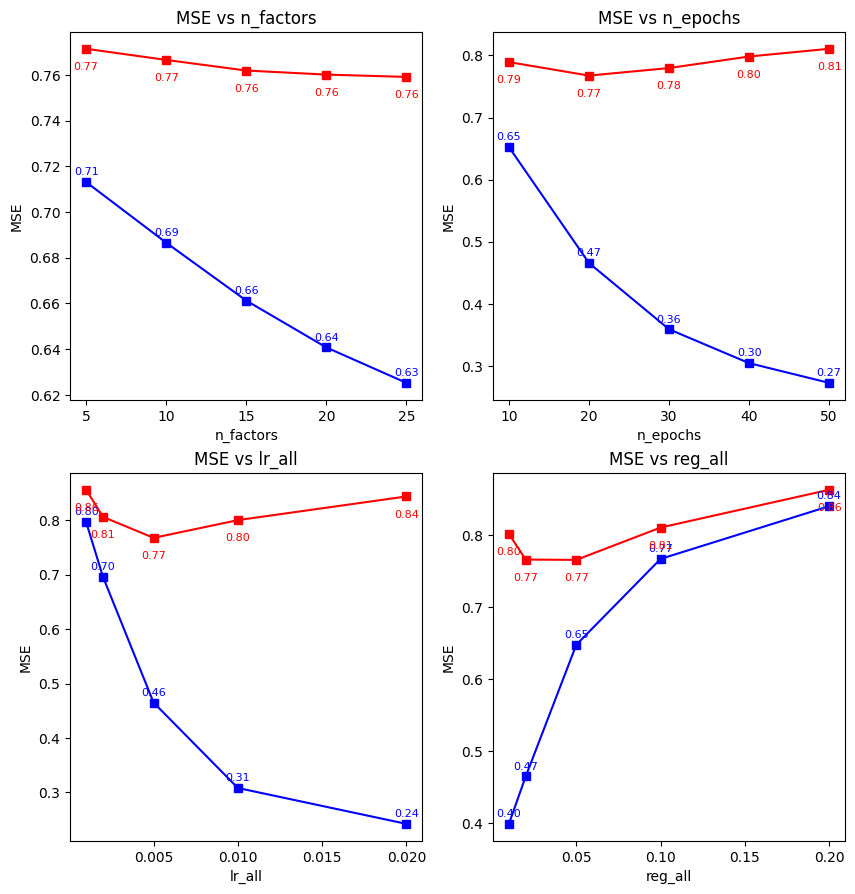

In [ ]:
fig1, ax1 = plt.subplots(2,2,figsize=(10,10.5))

for i in range(2):
    for j in range(2):
        ax1[i,j].plot(svd_param_values[i*2+j],svd_train_mse_results[svd_param_names[i*2+j]],color='b',marker='s')
        ax1[i,j].plot(svd_param_values[i*2+j],svd_test_mse_results[svd_param_names[i*2+j]],color='r',marker='s')
        ax1[i,j].set_xlabel(svd_param_names[i*2+j])
        ax1[i,j].set_ylabel('MSE')
        ax1[i,j].set_title(f'MSE vs {svd_param_names[i*2+j]}')

        for x, y in zip(svd_param_values[i * 2 + j], svd_train_mse_results[svd_param_names[i * 2 + j]]):
            ax1[i,j].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8,
                               color='b')

        for x, y in zip(svd_param_values[i * 2 + j], svd_test_mse_results[svd_param_names[i * 2 + j]]):
            ax1[i,j].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=8,
                               color='r')

**Note:** We observe that the training MSE declines for every hyperparameter except for the regularization hyperparameter, for which it increases. The test MSE reaches the best value at 0.76 . So now, we will combine the hyperparameter values that result in the best test MSE, and train a new SVD model, to check if we can reduce the test MSE.

In [ ]:
svd_model_1 = SVD(n_factors=25,n_epochs=20,lr_all=0.005,reg_all=0.02)
svd_model_1.fit(training_set)
predictions = svd_model_1.test(test_set)
mse = accuracy.mse(predictions)

MSE: 0.7558


**Conclusion:** The test MSE improved to a new best value at 0.7558.

# 8. Non-Negative Matrix Factorization (NMF)

Non-Negative Matrix Factorization (NMF) is a group of algorithms in multivariate analysis and linear algebra where a matrix V is decomposed into two matrices: $V = W \cdot H$

$V_{mxn}:$ The original user-item ratings matrix.<br>
$W_{mxk}:$ Non-negative matrix representing the user profiles in terms of the latent factors. Users with similar interaction patters have similar values in certain columns.<br>
$H_{kxn}:$ Non-negative matrix representing the item profiles in terms of the latent factors. Items that are associated with similar latent factors will have similar values in certain columns in H.

We used NMF from the surprise library, because it provides tools for hyperparameter tuning. We tuned four hyperparameters, one at a time, in order to observe the effect of each hyperparameter in the Mean Squared Error. The hyperparamater we tuned are:

**n_factors:** The number of latent factors. Increasing the number of latent factors allows the model to capture more complex patterns in the data, at the expense of computational cost.<br>
**n_epochs:** The number of iterations the NMF algorithm will perform on the training dataset.<br>
**reg_pu:** Parameter that controls the regularization strength applied to the user factors.<br>
**reg_qi:** Parameter that controls the regularization strength applied to the item factors.<br>

In [ ]:
from surprise import Reader, Dataset, NMF, accuracy
from surprise.model_selection import train_test_split
from contextlib import redirect_stdout

updated_df = df.drop(columns=['Date','Day_of_Week'], axis=1)
updated_df = updated_df[['User_ID', 'Movie_ID', 'Rating']]

reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(updated_df, reader)
training_set, test_set = train_test_split(data, test_size=0.2)

nmf_param_names = ['n_factors','n_epochs','reg_pu','reg_qi']

nmf_param_values = [[5, 10, 15, 20, 25], # number of factors
          [10, 20, 30, 40, 50], # number of epochs
          [0.001, 0.002, 0.005, 0.01, 0.02], # regularization term for user factors
          [0.001, 0.002, 0.005, 0.01, 0.02]] # regularization term for item factors

nmf_train_mse_results = {'n_factors': [], 'n_epochs': [], 'reg_pu': [], 'reg_qi': []}
nmf_test_mse_results = {'n_factors': [], 'n_epochs': [], 'reg_pu': [], 'reg_qi': []}

start_time = time.time()
for name, params in zip(nmf_param_names, nmf_param_values):
    for param in params:
        nmf_model = NMF(**{name:param})
        nmf_model.fit(training_set)
        with redirect_stdout(None):
            # Training MSE
            predictions = nmf_model.test(training_set.build_testset())
            mse = accuracy.mse(predictions)
            nmf_train_mse_results[name].append(mse)
            # Test MSE
            predictions = nmf_model.test(test_set)
            mse = accuracy.mse(predictions)  # Calculate Mean Squared Error
            nmf_test_mse_results[name].append(mse)

end_time = time.time()
elapsed_time = end_time - start_time
print("Total Execution Time of NMF: {:.3f} minutes".format(elapsed_time/60))

Total Execution Time of NMF: 20.349 minutes


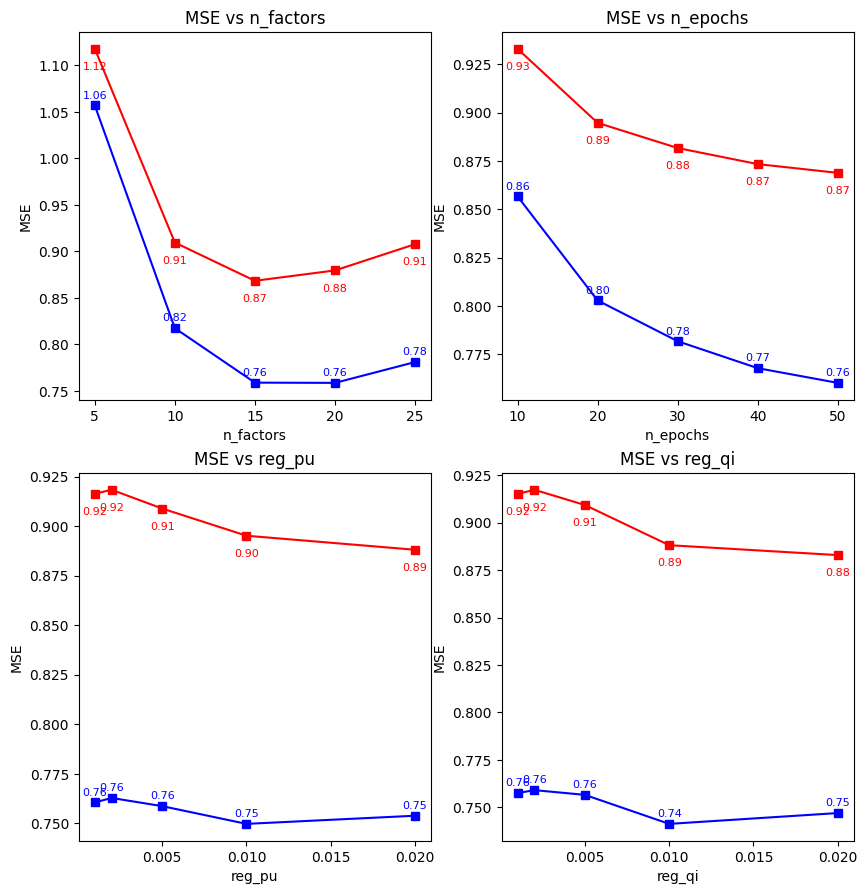

In [ ]:
fig2, ax2 = plt.subplots(2,2,figsize=(10,10.5))

for i in range(2):
    for j in range(2):
        ax2[i,j].plot(nmf_param_values[i*2+j],nmf_train_mse_results[nmf_param_names[i*2+j]],color='b',marker='s')
        ax2[i,j].plot(nmf_param_values[i*2+j],nmf_test_mse_results[nmf_param_names[i*2+j]],color='r',marker='s')
        ax2[i,j].set_xlabel(nmf_param_names[i*2+j])
        ax2[i,j].set_ylabel('MSE')
        ax2[i,j].set_title(f'MSE vs {nmf_param_names[i*2+j]}')

        for x, y in zip(nmf_param_values[i * 2 + j], nmf_train_mse_results[nmf_param_names[i * 2 + j]]):
            ax2[i,j].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8,
                               color='b')

        for x, y in zip(nmf_param_values[i * 2 + j], nmf_test_mse_results[nmf_param_names[i * 2 + j]]):
            ax2[i,j].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=8,
                               color='r')

**Note:** We observe that the training MSE declines for every hyperparameter. The test MSE reaches the best value at 0.87 . So now, we will combine the hyperparameter values that result in the best test MSE, and train a new NMF model, to check if we can reduce the test MSE.

In [ ]:
nmf_model_1 = NMF(n_factors=15,n_epochs=50,reg_pu=0.02,reg_qi=0.02)
nmf_model_1.fit(training_set)
predictions = nmf_model_1.test(test_set)
mse = accuracy.mse(predictions)

MSE: 0.9190


**Conclusion:** Combining the best hyperparameter values in a new NMF model, didn't result in the MSE's reduction.

# 9. Stochastic Gradient Descent (SGD)

We initializes random latent factor matrices for users (U) and items (V) and we perform SGD updates for the specified number of iterations. Then we evaluate using mean squared error.

This is the general implementation:

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Parameters/Hyperparameters
num_users = len(user_to_index)
num_items = len(movie_to_index)
num_latent_factors = 10
learning_rate = 0.1
lambda_reg = 0.01
num_iterations = 200

sparse_matrix_csr_float = sparse.csr_matrix(sparse_matrix_csr, dtype=np.float64)

# Random initialization of latent factor matrices
U = np.random.rand(num_users, num_latent_factors)
V = np.random.rand(num_items, num_latent_factors)

# Stochastic Gradient Descent algorithm
for iteration in range(num_iterations):
    # We can shuffle the data indices for each iteration if we want
    shuffled_indices = np.random.permutation(len(user_indices))

    # Random selection of data points
    for idx in shuffled_indices[:num_iterations]:
        user_idx = user_indices[idx]
        item_idx = movie_indices[idx]
        rating = df['Rating'].iloc[idx]

        # Calculate error and update latent factors
        error = rating - np.dot(U[user_idx], V[item_idx])
        U[user_idx] += learning_rate * (error * V[item_idx] - lambda_reg * U[user_idx])
        V[item_idx] += learning_rate * (error * U[user_idx] - lambda_reg * V[item_idx])

# Making the prediction
predicted_matrix_sgd = np.dot(U, V.T)

# Evaluating performance using MSE
non_zero_indexes = sparse_matrix_csr_float.nonzero()
actual_ratings_sgd = sparse_matrix_csr_float[non_zero_indexes].A.flatten()
predicted_ratings_sgd = predicted_matrix_sgd[non_zero_indexes].flatten()

mse_sgd = mean_squared_error(actual_ratings_sgd, predicted_ratings_sgd)
print(f"SGD Mean Squared Error: {mse_sgd}")

SGD Mean Squared Error: 1.6802482575424218


#### Hyperparameter tuning

There are several hyperparameters that we use for our algorithm. We run several tests with different combinations of values for these hyperparameters. The following are some indicative results that show the effect that each hyperparameter has on the accuracy of the algorithm:

-

The **learning rate** determines the step size during parameter updates. Too high of a learning rate can cause the algorithm to converge slowly or even diverge, while too low of a learning rate may result in slow convergence or getting stuck in local minima.

| Learning Rate | Mean Squared Error |
|:---------|:--------:|
|  0.001   |  2.874075394668591   |
|  0.01   |  2.7674699165899135  |
|  0.1   |  2.1502139073505755   |
|  0.2   |  2.655999321942788   |

Looking at the table above, we see that a learning rate of 0.1 yields the best results, therefore we choose that.

-

**Regularization** helps prevent overfitting by penalizing large values in the latent factor matrices. Too much regularization may lead to underfitting, while too little may result in overfitting.

| Lambda Regulation | Mean Squared Error |
|:---------|:--------:|
|  0.01   |  2.129491380447938  |
|  0.1   |  2.164994362365267   |
|  1.0   |  2.588200920133118   |

Here, a lambda_reg value of 0.01 gives us the better result, although the difference between that and the results for the value 0.1 are realtively close.

-

The number of **latent factors** represents the dimensionality of the feature space for the users and the items. Too few latent factors may lead to underfitting, whereas too many may result in overfitting.

| # of Latent Factors | Mean Squared Error |
|:---------|:--------:|
|  5   |  4.625558863806613  |
|  10   |  2.1407417015407475   |
|  20   |  2.679450799139848   |

We choose to use 10 latent factors as it seems to be the best/most balanced choice.

-

The number of **iterations** determines how many times the algorithm will loop to try and minimize the error. Too few iterations may result in underfitting and inaccurate results, while too many may lead to overfitting or slow convergence, and of course an increased execution time.

| # of Iterations | Mean Squared Error |
|:---------|:--------:|
|  50   |  2.15074861540788970  |
|  100   |  1.7765457910687599   |
|  200   |  1.7162475745958714   |

Finally, 200 iterations seemed like a good enough number. The rate that the performance increases after ~100 iterations drops pretty rapidly, so going that mark is not very efficient. Still, at 200, we have an acceptable execution time and decent performance.



# 10. K Nearest Neighbors (KNN)

We train the model using our training set, and then for each user-item pair in the test set we find the average rating of it's nearest neighbors, which in the end is our prediction. This is very computationally expensive. That is why we choose to use the "kd_tree" algorithm. KD-trees are more efficient than brute-force search algorithms, especially for large datasets.

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)


# Training the KNN model using KDTree
knn = NearestNeighbors(n_neighbors=30, algorithm='kd_tree')
knn.fit(train_df[['User_ID', 'Movie_ID']].values)

# Making predictions on the test set
test_user_ids = test_df['User_ID'].values
test_movie_ids = test_df['Movie_ID'].values

predicted_ratings = []

for user_id, movie_id in zip(test_user_ids, test_movie_ids):
    neighbors = knn.kneighbors([(user_id, movie_id)])
    neighbor_ratings = train_df['Rating'].iloc[neighbors[1][0]]

    predicted_rating = np.mean(neighbor_ratings)
    predicted_ratings.append(predicted_rating)

# Evaluating performance using MSE
actual_ratings = test_df['Rating'].values
mse_knn = mean_squared_error(actual_ratings, predicted_ratings)
print(f"KNN Mean Squared Error: {mse_knn}")

KNN Mean Squared Error: 1.1706721087375886


#### Hyperparameter tuning

We can change the number for neighbors (k) that we are looking for, to see which value gives us the best results. Small values may be more sensitive to noise and outliers which may lead to overfitting, while larger values
should make more smooth/general predictions but might miss local patterns. Very large k values will also make a noticeable difference in the execution time.

| # of neighbors | Mean Squared Error |
|:---------|:--------:|
|  5   |  1.3051213261849535  |
|  10   |  1.2166817723468317   |
|  20   |  1.1811520802690894   |
|  40   |  1.165747865259876   |
|  60   |  1.1632004150022737   |


Looking at the table above we can see that the benefit of increasing the number of neighbors starts to fall off rapidly at higher values.



# 11. Featurizing Data

Featurization is the process of transforming raw data into a format that is suitable for machine learning models. The goal is to create a set of new meaningful features that capture relevant information from the original data. This is necessary in order to make use of Regression ML models on our Recommendation System Project.

First, we need to build sample train data from the train data.

In [ ]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies):

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    np.random.seed(42)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)

    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )

    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
    print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Done')

    return sample_sparse_matrix

In [ ]:
num_train_users = len(np.unique(train_data["User_ID"]))
num_train_movies = len(np.unique(train_data["Movie_ID"]))
num_test_users = len(np.unique(test_data["User_ID"]))
num_test_movies = len(np.unique(test_data["Movie_ID"]))

In [ ]:
sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=500, no_movies=1000)
sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=500, no_movies=2000)

Original Matrix : (users, movies) -- (9989 17015)
Original Matrix : Ratings -- 1677955

Sampled Matrix : (users, movies) -- (500 1000)
Sampled Matrix : Ratings -- 6236
Done
Original Matrix : (users, movies) -- (9833 13586)
Original Matrix : Ratings -- 419489

Sampled Matrix : (users, movies) -- (500 2000)
Sampled Matrix : Ratings -- 3463
Done


Now, we got to find the Global Averages from Sampled Train

In [ ]:
def get_average_ratings(sparse_matrix, of_users):
    ax = 1 if of_users else 0

    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    is_rated = sparse_matrix != 0
    no_of_ratings = is_rated.sum(axis=ax).A1

    u,m = sparse_matrix.shape
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m)
                                    if no_of_ratings[i] !=0}
    return average_ratings

In [ ]:
sample_train_averages = dict()

global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
print('Global Average: ',sample_train_averages)

sample_train_averages['User_ID'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
# print('Average rating of User_ID 527 :',sample_train_averages['User_ID'][527])

sample_train_averages['Movie_ID'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
# print('Average rating of Movie_ID 15875 :',sample_train_averages['Movie_ID'][15875])

Global Average:  {'global': 3.632937780628608}


In [ ]:
sample_test_averages = dict()

global_average = sample_test_sparse_matrix.sum()/sample_test_sparse_matrix.count_nonzero()
sample_test_averages['global'] = global_average
print('Global Average: ',sample_test_averages)

sample_test_averages['User_ID'] = get_average_ratings(sample_test_sparse_matrix, of_users=True)
# print('Average rating of User_ID 44317 :',sample_test_averages['User_ID'][44317])

sample_test_averages['Movie_ID'] =  get_average_ratings(sample_test_sparse_matrix, of_users=False)
# print('Average rating of Movie_ID 16731 :',sample_test_averages['Movie_ID'][16731])

Global Average:  {'global': 3.5890846087207624}


In [ ]:
print('No of ratings in Our Sampled train matrix is : {}'.format(sample_train_sparse_matrix.count_nonzero()))
print('No of ratings in Our Sampled test  matrix is : {}'.format(sample_test_sparse_matrix.count_nonzero()))

No of ratings in Our Sampled train matrix is : 6236
No of ratings in Our Sampled test  matrix is : 3463


In [ ]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

Preparing new features for Train Set

In [ ]:
start = datetime.now()

reg_train = []
count = 0

print('preparing {} tuples for the dataset..'.format(len(sample_train_ratings)))

for (user, movie, rating) in zip(sample_train_users, sample_train_movies, sample_train_ratings):
    st = datetime.now()

    # Similar Users
    user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
    top_sim_users = user_sim.argsort()[::-1][1:]
    top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
    top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
    top_sim_users_ratings.extend([sample_train_averages['Movie_ID'][movie]] * (5 - len(top_sim_users_ratings)))

    # Similar Movies
    movie_sim = cosine_similarity(sample_train_sparse_matrix[:, movie].T, sample_train_sparse_matrix.T).ravel()
    top_sim_movies = movie_sim.argsort()[::-1][1:]
    top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
    top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
    top_sim_movies_ratings.extend([sample_train_averages['User_ID'][user]] * (5 - len(top_sim_movies_ratings)))

    # Prepare the row
    row = [user, movie, sample_train_averages['global']] + top_sim_users_ratings + top_sim_movies_ratings + \
            [sample_train_averages['User_ID'][user], sample_train_averages['Movie_ID'][movie], rating]

    # Append the row to the list
    reg_train.append(row)
    count += 1

print('duration: ', datetime.now() - start)


preparing 6236 tuples for the dataset..
duration:  0:00:58.994415


In [ ]:
reg_train_df = pd.DataFrame(reg_train, columns=['User_ID', 'Movie_ID', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'Rating'])
reg_train_df.head()

,User_ID,Movie_ID,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,Rating
0,10,299,3.632938,3.0,5.0,4.0,3.0,2.0,5.0,3.0,4.0,3.0,4.0,3.75,3.828571,2
1,10,3254,3.632938,3.0,4.0,2.0,4.0,3.0,4.0,3.0,4.0,4.0,5.0,3.75,3.150685,4
2,10,4661,3.632938,3.0,4.0,4.0,3.0,2.0,3.0,4.0,4.0,4.0,5.0,3.75,3.375000,4
3,10,5181,3.632938,4.0,4.0,1.0,4.0,3.0,2.0,4.0,3.0,5.0,5.0,3.75,3.440000,5
4,10,5199,3.632938,4.0,2.0,3.0,3.0,3.0,4.0,2.0,4.0,4.0,2.0,3.75,3.000000,3


So, we have created these features for our ratings:

- `GAvg` : Average rating of all the ratings

- `sur1`, `sur2`, `sur3`, `sur4`, `sur5`: Top 5 similar users who rated that movie

- `smr1`, `smr2`, `smr3`, `smr4`, `smr5`: Top 5 similar movies rated by this movie

- `UAvg` : User's Average rating

- `MAvg` : Average rating of this movie

- `Rating` : Rating of this movie by this user.



Now, we are going to do the same for our Test Sample sparse matrix

In [ ]:
# get users, movies and ratings from the Sampled Test
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [ ]:
start = datetime.now()

reg_test = []
count = 0

print('preparing {} tuples for the dataset..'.format(len(sample_test_ratings)))

for (user, movie, rating) in zip(sample_test_users, sample_test_movies, sample_test_ratings):
    st = datetime.now()

    # Similar Users
    user_sim = cosine_similarity(sample_test_sparse_matrix[user], sample_test_sparse_matrix).ravel()
    top_sim_users = user_sim.argsort()[::-1][1:]
    top_ratings = sample_test_sparse_matrix[top_sim_users, movie].toarray().ravel()
    top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
    top_sim_users_ratings.extend([sample_test_averages['Movie_ID'][movie]] * (5 - len(top_sim_users_ratings)))

    # Similar Movies
    movie_sim = cosine_similarity(sample_test_sparse_matrix[:, movie].T, sample_test_sparse_matrix.T).ravel()
    top_sim_movies = movie_sim.argsort()[::-1][1:]
    top_ratings = sample_test_sparse_matrix[user, top_sim_movies].toarray().ravel()
    top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
    top_sim_movies_ratings.extend([sample_test_averages['User_ID'][user]] * (5 - len(top_sim_movies_ratings)))

    # Prepare the row
    row = [user, movie, sample_test_averages['global']] + top_sim_users_ratings + top_sim_movies_ratings + \
            [sample_test_averages['User_ID'][user], sample_test_averages['Movie_ID'][movie], rating]

    # Append the row to the list
    reg_test.append(row)
    count += 1

print('duration: ', datetime.now() - start)


preparing 3463 tuples for the dataset..
duration:  0:00:31.028833


In [ ]:
reg_test_df = pd.DataFrame(reg_test, columns=['User_ID', 'Movie_ID', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'Rating'])
reg_test_df.head()

,User_ID,Movie_ID,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,Rating
0,6,329,3.589085,3.0,3.0,3.0,5.0,2.0,4.0,3.0,4.0,4.0,4.0,3.684211,3.076923,4
1,6,1267,3.589085,3.0,3.0,4.0,3.0,2.0,4.0,3.0,4.0,4.0,4.0,3.684211,3.066667,3
2,6,2857,3.589085,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,3.684211,4.000000,4
3,6,3427,3.589085,4.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,3.684211,3.384615,4
4,6,3638,3.589085,5.0,4.0,1.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.684211,3.285714,4


# 12. XGBoost

XGBoost, which stands for eXtreme Gradient BOOSTing, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems.

In [ ]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    mse = np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ])
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return mse, rmse, mape


def run_xgboost(algo, x_train, y_train, x_test, y_test):
    train_results = dict()
    test_results = dict()

    print('Training the model..')
    start = datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)

    mse_train, rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)

    train_results = {'mse' : mse_train,
                    'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}

    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test)
    mse_test, rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)

    test_results = {'mse' : mse_test,
                    'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    print('\nTEST DATA')
    print('-'*30)
    print('MSE  : ', mse_test)
    print('RMSE : ', rmse_test)
    print('MAPE : ', mape_test)

    return train_results, test_results

Training the model..


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:53:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Done. Time taken : 0:00:00.487682

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
MSE  :  0.6150710577891204
RMSE :  0.784264660550965
MAPE :  22.005606738776788


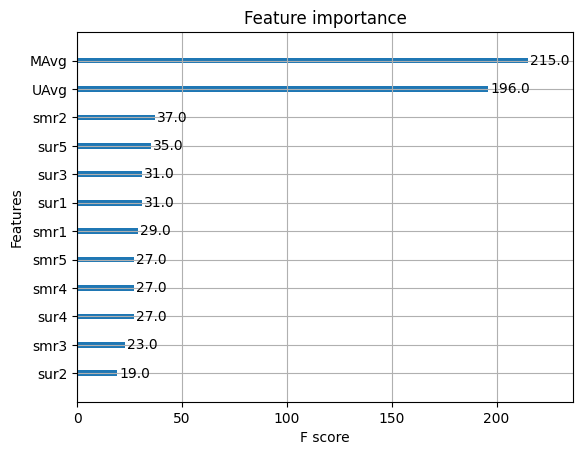

In [ ]:
# prepare Train data
X_train = reg_train_df.drop(['User_ID','Movie_ID','Rating'], axis=1)
y_train = reg_train_df['Rating']

# Prepare Test data
X_test = reg_test_df.drop(['User_ID','Movie_ID','Rating'], axis=1)
y_test = reg_test_df['Rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
train_results, test_results = run_xgboost(first_xgb, X_train, y_train, X_test, y_test)

xgb.plot_importance(first_xgb)
plt.show()

#### Hyperparameter tuning

There are several hyperparameters that we use for our algorithm. We run several tests with different combinations of values for these hyperparameters. The following are some indicative results that show the effect that each hyperparameter has on the accuracy of the algorithm:

-

The **Estimators** parameter specifies the number of boosting rounds or trees to build in the model. Each boosting round contributes an additional weak learner (tree) to the overall model. Increasing this value of generally improves the performance of the model on the training data, but it may also increase the risk of overfitting.

| Estimators | Mean Squared Error |
|:---------|:--------:|
|  100   |  0.659999   |
|  500   |  0.678063  |
|  1000   |  0.705987   |
|  2000   |  0.736391   |

Looking at the table above, we see that 100 estimators yields the best results, therefore we choose that.

-

The **Learning Rate** determines the step size during parameter updates. Too high of a learning rate can cause the algorithm to converge slowly or even diverge, while too low of a learning rate may result in slow convergence or getting stuck in local minima.

| Learning Rate | Mean Squared Error |
|:---------|:--------:|
|  0.005   |  0.917871  |
|  0.05   |  0.662977  |
|  0.1   |  0.659993   |
|  0.2   |  0.673448   |
|  0.5   |  0.715653   |

Looking at the table above, we see that a learning rate of 0.1 yields the best results, therefore we choose that.

-

**Max Depth** helps prevent overfitting by penalizing large values in the latent factor matrices. Too much regularization may lead to underfitting, while too little may result in overfitting.

| Max Depth | Mean Squared Error |
|:---------|:--------:|
|  1   |  0.675069  |
|  2   |  0.667959   |
|  3   |  0.659999   |
|  4   |  0.662196   |
|  5   |  0.672184   |

Here, a max_depth of 3, gives us the best smallest error on our model.

-

So, we can see that the best combination of hyperparameters is:

- `n_estimators` = 100
- `learning_rate` = 0.1
- `max_depth` = 3

After running the model with these hyperparameters, we find a Mean Squared Error of `0.615071`.

# 13. Surprise Baseline Model

Baseline models play a crucial role in recommendation systems as they provide a simple yet effective way to establish a baseline performance. These models are typically straightforward and serve as a starting point for more sophisticated recommendation algorithms. In this project, we are going to create a BaselineOnly model that is going to be a baseline for the XGBoost algorithm.

The BaseOnly algorithm uses this formula to predict the rating:

$$
r_{ui} = \mu + b_u + b_i
$$

where,
- $r_{ui}$ : Prediction of user $u$ for item $i$  
- $\mu$ : Average of all trainings in training data
- $b_u$ : User bias
- $b_i$ : Item bias

We are going to use the `surprise` library.

In [ ]:
from surprise import BaselineOnly, Reader, Dataset

In [ ]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])

    return actual, pred

def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    mse = np.mean((pred - actual)**2)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return mse, rmse, mape*100

# It returns two dictionaries, one for train and the other is for test
# Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''
def run_surprise(algo, trainset, testset, verbose=True):
    start = datetime.now()

    train = dict()
    test = dict()

    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))


    st = datetime.now()
    print('Evaluating the model with train data..')
    train_preds = algo.test(trainset.build_testset())
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    train_mse, train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))

    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("MSE: {}\n\nRMSE : {}\n\nMAPE : {}\n".format(train_mse, train_rmse, train_mape))

    if verbose:
        print('adding train results in the dictionary..')
    train['mse'] = train_mse
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings


    st = datetime.now()
    print('\nEvaluating for test data...')
    test_preds = algo.test(testset)
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    test_mse, test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))

    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("MSE: {}\n\nRMSE : {}\n\nMAPE : {}\n".format(test_mse, test_rmse, test_mape))

    if verbose:
        print('storing the test results in test dictionary...')
    test['mse'] = test_mse
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings

    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)

    return train, test

In [ ]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train_df[['User_ID', 'Movie_ID', 'Rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset()

In [ ]:
testset = list(zip(reg_test_df.User_ID.values, reg_test_df.Movie_ID.values, reg_test_df.Rating.values))
testset[:3]

[(10, 2578, 3), (10, 2782, 4), (10, 4345, 4)]

In [ ]:
bsl_options = {'method': 'sgd',
               'learning_rate': 0.01,
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.052675 

Evaluating the model with train data..
time taken : 0:00:00.036758
---------------
Train Data
---------------
MSE: 0.7460461341858894

RMSE : 0.863739621752927

MAPE : 25.59809607448116

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.036783
---------------
Test Data
---------------
MSE: 1.1788517784116161

RMSE : 1.0857494086627983

MAPE : 35.59194232990917

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.130422


#### Hyperparameter tuning

We can call the BaselineOnly model for different Learning Rates. After experimenting with it, the following errors could be found:

| Learning Rate | Mean Squared Error |
|:---------|:--------:|
|  0.001   |  1.184479  |
|  0.01   |  1.178852   |
|  0.1   |  1.180751   |
|  0.5   |  1.219276   |


We can see that for learning rate of 0.01 we get the best perfomace of the model. So wee keep that hyperparameter.



# 14. XGBoost with initial 13 features + Surprise Baseline predictor

After running the baseline model, now we are going to use its predictions as a feature/input for the XGBoost model.

In [ ]:
# add our baseline_predicted value as our feature
reg_train_df['bslpr'] = bsl_train_results['predictions']
display(reg_train_df.head(2))

reg_test_df['bslpr']  = bsl_test_results['predictions']
reg_test_df.head(2)

,User_ID,Movie_ID,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,Rating,bslpr
0,10,571,3.714603,3.0,5.0,5.0,5.0,3.0,4.0,4.0,3.0,5.0,4.0,3.615385,3.95122,4,3.836182
1,10,1744,3.714603,5.0,4.0,4.0,3.0,3.0,4.0,5.0,4.0,4.0,4.0,3.615385,3.96875,3,3.700792


,User_ID,Movie_ID,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,Rating,bslpr
0,10,2578,3.615986,3.0,5.0,4.0,3.0,5.0,1.0,3.0,4.0,5.0,3.0,3.285714,3.714286,3,3.498141
1,10,2782,3.615986,4.0,5.0,5.0,5.0,5.0,5.0,4.0,1.0,3.0,3.0,3.285714,4.714286,4,3.498141


Training the model..


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:57:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Done. Time taken : 0:00:01.094316

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
MSE  :  0.9319350072906942
RMSE :  0.9653678093300472
MAPE :  29.08238336187101


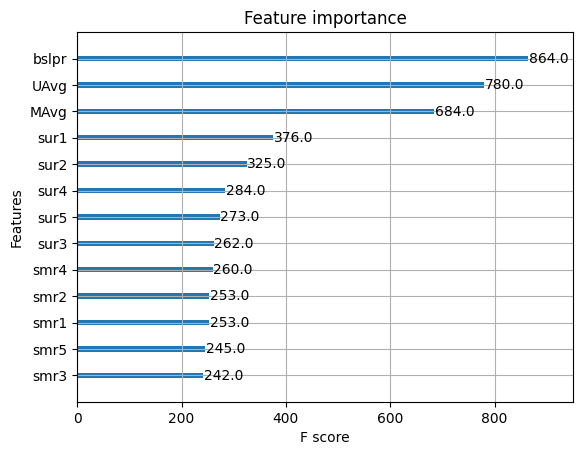

In [ ]:
# prepare train data
X_train = reg_train_df.drop(['User_ID', 'Movie_ID','Rating'], axis=1)
y_train = reg_train_df['Rating']

# Prepare Test data
X_test = reg_test_df.drop(['User_ID','Movie_ID','Rating'], axis=1)
y_test = reg_test_df['Rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=142, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, X_train, y_train, X_test, y_test)

xgb.plot_importance(xgb_bsl)
plt.show()

Now, we have to compare this model's performance with XGBoost:

| Model           |   Mean Squared Error   |
|-----------------|------------------------|
| XGBoost                 |        0.615071        |
| XGBoost + Baseline      |        0.931935        |

In our evaluation of the two models, we initially anticipated that the XGBoost + Baseline model would perform better than the XGBoost model, because of the extra information it was given. However, the XGBoost + Baseline's MSE is `worse` than the XBoost's.

# 15. Neural Collaborative Filtering (NCF)

In this segment, we are going to use a neural network in order to model the user-movie interactions. This type of recommendation system is called Neural Collaborative Filtering (NCF).

NCF was introduced to address some of the limitations of traditional collaborative filtering methods, such as matrix factorization, by incorporating non-linearities and capturing complex patterns in user-item relationships.

The layers of the neural network we are going to use, that we can also see in the plots below, are:

---------------------------------------------------------------------------
### User Layers
- `User Input Layer`: a one-dimensional input layer that takes in the User_ID
- `User Embedding Layer`: an embedding layer that converts the User_ID into a dense vector representation of size 10 (Latent Features)
- `User Flattening Layer`: a flattening layer that flattens the output of the user embedding layer into a one-dimensional vector

---------------------------------------------------------------------------
### Movie Layers
- `Movie Input Layer`: a one-dimensional input layer that takes in the Movie_ID
- `Movie Embedding Layer`: an embedding layer that converts the Movie_ID into a dense vector representation of size 10 (Latent Features)
- `Movie Flattening Layer`: a flattening layer that flattens the output of the user embedding layer into a one-dimensional vector

---------------------------------------------------------------------------
### Dot-Product Layers
- `Dot-Product Layer (Concat)`: takes the flattened movie and user vectors and computes their dot product. This produces a single value that represents the similarity between the movie and user
---------------------------------------------------------------------------
### Dropout Layers
- `Concut Dropout Layer`: introduces some randomness into the model by randomly setting some of the values in the output of the concat layer to zero. This helps to prevent overfitting
- `FC Dropout Layers (3 layers)`: these layers are similar to concat dropout layer, but they are applied to the outputs of the Dense layers
---------------------------------------------------------------------------
### Dense Layers
- `FC 1`: applies a fully connected layer with 100 units and a ReLU activation function to the output of the concat dropout layer
- `FC 2`: another fully connected layer with 50 units and a ReLU activation function
- `FC 3`: the final fully connected layer with 1 unit and a sigmoid activation function. This layer outputs the predicted rating for the movie and user


In [ ]:
import keras
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, Dot
from keras.optimizers import Adam
from keras.utils import model_to_dot
from keras.utils import plot_model
from IPython.display import SVG

In [ ]:
train_data, test_data = train_test_split(df[['User_ID', 'Movie_ID', 'Rating']], test_size=0.2, random_state=42)
train_data.head()

,User_ID,Movie_ID,Rating
559140,8055,4801,3
1014218,43185,14240,4
1204689,43489,8387,5
1121051,40031,11314,3
842579,54870,4290,1


In [ ]:
@tf.function
def custom_loss(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

In [ ]:
latent_dim = 50

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

concat = Dot(axes=1, normalize=True, name='movie-user-dot')([movie_vec, user_vec])
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat)
fc_1_dropout = Dropout(0.2, name='fc-1-dropout')(fc_1)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.2, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)


model = Model([user_input, movie_input], fc_3)
model.compile(
    loss=custom_loss,
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movie-input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user-input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie-embedding (Embedding  (None, 1, 50)                865050    ['movie-input[0][0]']         
 )                                                                                                
                                                                                                  
 user-embedding (Embedding)  (None, 1, 50)                500050    ['user-input[0][0]']      

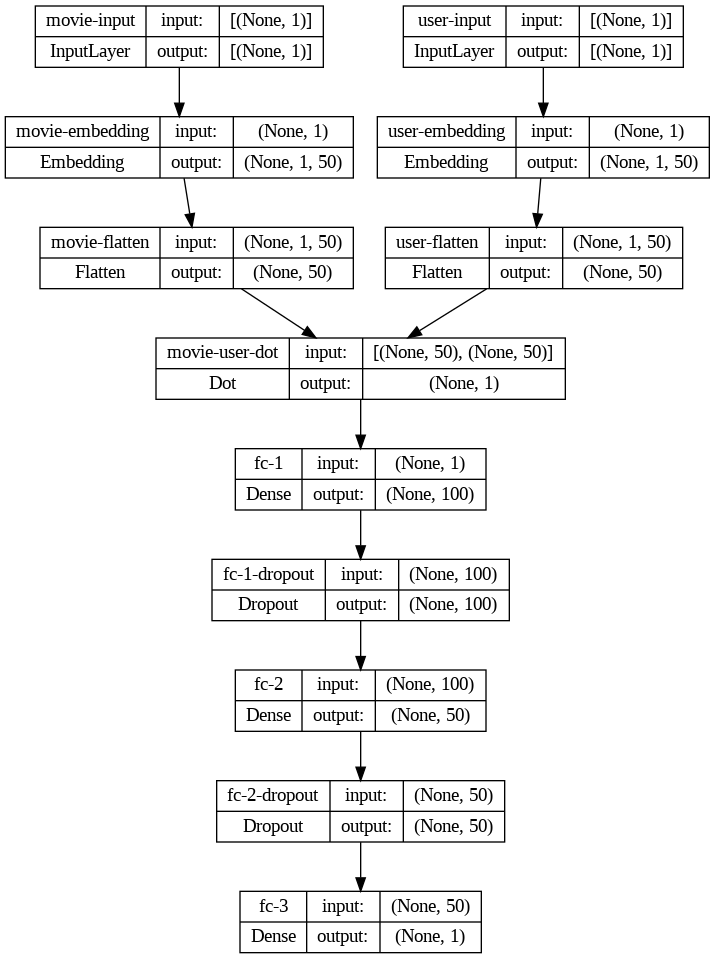

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
start = datetime.now()
history = model.fit(
    [train_data.User_ID, train_data.Movie_ID],
    train_data.Rating,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_split=0.2,
)
print('training duration: {}'.format(datetime.now() - start))

Epoch 1/5
20975/20975 [==============================] - 125s 6ms/step - loss: 1.1884 - val_loss: 1.1710
Epoch 2/5
20975/20975 [==============================] - 116s 6ms/step - loss: 1.1727 - val_loss: 1.1715
Epoch 3/5
20975/20975 [==============================] - 110s 5ms/step - loss: 1.1689 - val_loss: 1.1679
Epoch 4/5
20975/20975 [==============================] - 113s 5ms/step - loss: 1.1640 - val_loss: 1.1654
Epoch 5/5
20975/20975 [==============================] - 115s 6ms/step - loss: 1.1589 - val_loss: 1.1633
training duration: 0:09:39.916138


In [ ]:
mse = model.evaluate([test_data.User_ID, test_data.Movie_ID], test_data.Rating)
print(f'Mean Squared Error on Test Set: {mse}')

13110/13110 [==============================] - 31s 2ms/step - loss: 1.1665
Mean Squared Error on Test Set: 1.1665444374084473


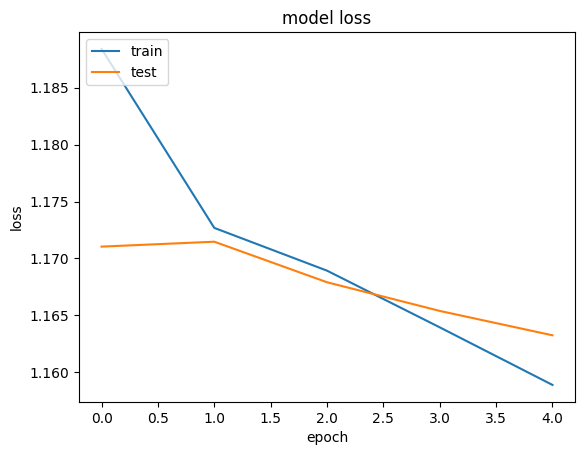

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

#### Hyperparameter tuning
-

The **Latent Dimensions** parameter specifies the number of of the latent features of the embedding space of both users and movies. The more latent features we have, the more parameters can be trained, hence better performance.

| Dimensions | Trainable Parameters | Training Time | Mean Squared Error |
|:---------|:---------|:---------|:--------:|
|  10   |   278,321   |   0:08:42   |  1.173863   |
|  20   |   551,341   |   0:09:22   |  1.173746   |
|  50   |  1,370,401  |   0:08:26   |  1.171590   |
|  100  |  2,735,501  |   0:09:06   |  1.174202   |

Looking at the table above, we can conclude to the following: the training time doesn't change much when increasing the dimensions, the trainable parameters are proportional το the dimensions. Also and most important, the MSE stays around the same, something that we didn't expect. However, when the latent dimension are 50, we get a slightly better MSE (**1.171590**).

-

**Epochs** define the number of times the entire training dataset is passed forward and backward through the neural network during training. We'll see the model responds to running different epoch numbers.

|  Epochs  | Training Time | Mean Squared Error |
|:---------|:---------|:--------:|
|   5   |  0:08:26  |  1.171590  |
|  10   |  0:17:19  |  1.173537  |
|  20   |  0:35:07  |  1.148805  |

Looking at the table above, we see that a learning rate of 0.1 yields the best results, therefore we choose that.

-

So, we can see that the best combination of hyperparameters is:

- `n_estimators` = 100
- `learning_rate` = 0.1
- `max_depth` = 3

After running the model with these hyperparameters, we find a Mean Squared Error of `1.166544`.